In [2]:
from music21 import *
import os
from collections import defaultdict
from pprint import *
import numpy as np

PITCHES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
OCTAVES = 7 #1 through 7
base_dir = 'wikifonia_en_chords_lyrics'

In [66]:
def all_notes():
    notes = []
    for o in range(OCTAVES):
        for p in PITCHES:

            notes.append(p + str(o+1))
    return notes
ALL_NOTES = all_notes()
ALL_NOTES[36]

'C4'

In [3]:

NUM_PITCHES = 12
MATRIX_SIZE = NUM_PITCHES * OCTAVES
# MATRIX_SIZE = NUM_PITCHES * OCTAVES

def noteToIndex(n):
    return int(n.pitch.ps)-24

assert(noteToIndex(note.Note("C4"))==36)

"""
Given a score, generates the transition matrix. Helper function
for `generateTransitionMatrix` below.
NOTE: only works for C Major, transpose the piece to CM.
"""
def getTransitions(score): 
    matrix = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=np.uintc)
    transitions = {}
    notes = [n for n in score.recurse() if type(n) == note.Note]
    last_note = notes[0]
    for n in notes[1:]:
        last_idx = noteToIndex(last_note)
        cur_idx = noteToIndex(n)
        matrix[last_idx, cur_idx] += 1
        last_note = n
    return matrix
    
# debug transitions
# f = os.listdir(base_dir)[3]
# path = os.path.join(base_dir,f)
# score = converter.parse(path)
# matrix = getTransitions(score)
# matrix

In [67]:
# ############SMALL#############

# NUM_PITCHES = 12
# # MATRIX_SIZE = NUM_PITCHES * OCTAVES
# MATRIX_SIZE = 12

# def noteToIndex(n):
#     return int(n.pitch.ps)%12

# # assert(noteToIndex(note.Note("C4"))==36)

# """
# Given a score, generates the transition matrix. Helper function
# for `generateTransitionMatrix` below.
# NOTE: only works for C Major, transpose the piece to CM.
# """
# def getTransitions(score): 
#     matrix = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=np.uintc)
#     transitions = {}
#     notes = [n for n in score.recurse() if type(n) == note.Note]
#     last_note = notes[0]
#     for n in notes[1:]:
#         last_idx = noteToIndex(last_note)
#         cur_idx = noteToIndex(n)
#         matrix[last_idx, cur_idx] += 1
#         last_note = n
#     return matrix
    
# # debug transitions
# # f = os.listdir(base_dir)[3]
# # path = os.path.join(base_dir,f)
# # score = converter.parse(path)
# # matrix = getTransitions(score)
# # matrix

# """prints transition matrix. looks slightly cancerous but it works"""
# def printTransitionMatrix(matrix, tabsize=4):
#     print(("\t" + "\t".join(PITCHES)).expandtabs(tabsize))
#     for i in range(matrix.shape[0]):
#         print((PITCHES[i] + "\t" + "\t".join((str(s) for s in list(matrix[i])))).expandtabs(tabsize))
    
# # example
# # f = os.listdir(base_dir)[5] 
# # path = os.path.join(base_dir,f)
# # score = converter.parse(path) 
# # m = getTransitions(score)
# # printTransitionMatrix(m, tabsize=3)

# """ 
# Generates transitiion matrix for first 10 C Major pieces
# Currently filters for CM, can add in transposition later
# """
# def generateTransitionMatrix(base_dir, load=True, save=False):
#     path = 'pitch_to_pitch.npy'
#     if load:
#         with open(path, 'rb') as f:
#             a = np.load(f)
#         return a
#     else:
#         count = 0
#         count_not = 0
#         num_pieces = 10
#         matrix = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=np.uintc)
#         for i in range(len(os.listdir(base_dir))):
#             f = os.listdir(base_dir)[i]
#             try:
#                 path = os.path.join(base_dir,f)
#                 score = converter.parse(path)
#             except: 
#                 continue
#             score = transpose_to_c(score)
#             k = score.analyze('key')

#             if k.name == "C major":
#                 m = getTransitions(score)
#                 matrix = matrix + m
#                 count += 1
#             else:
#                 count_not += 1

#             if count >= num_pieces:
#                 break
#         matrix = (matrix)
        
#         if save:
#             with open(path, 'wb+') as f:
#                 np.save(f, matrix)

#         return matrix

# matrix = generateTransitionMatrix(base_dir, load=False, save=False)
# # matrix
# # printTransitionMatrix(matrix)

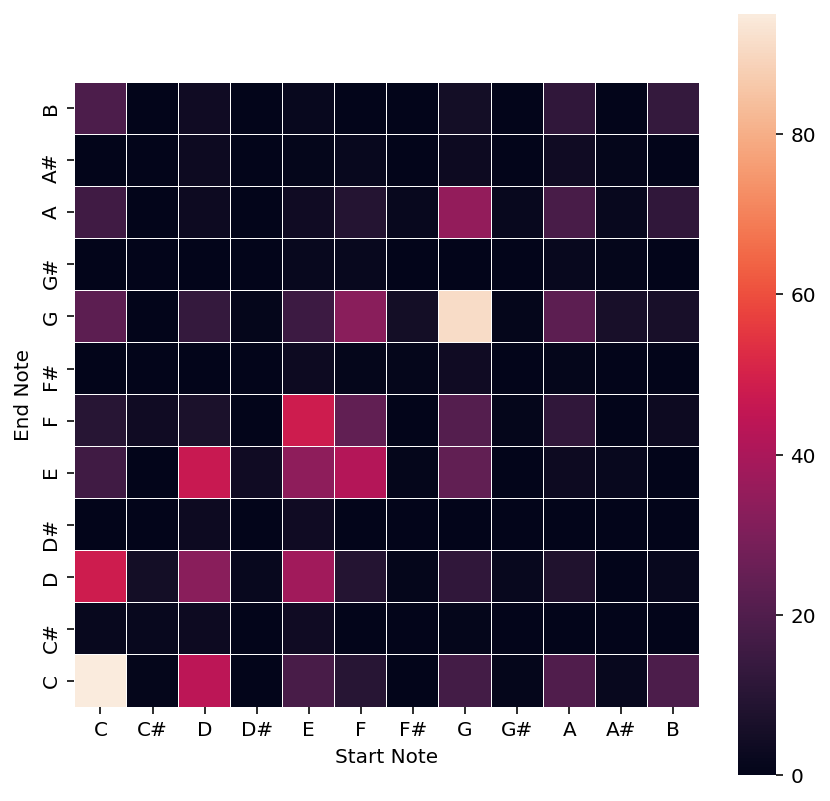

In [56]:
import seaborn as sns
import matplotlib.pylab as plt

f, ax = plt.subplots(figsize=(7,7))
ax = sns.heatmap(matrix, linewidth=0.01, square=True, xticklabels=PITCHES, yticklabels=PITCHES)
ax.set_ylabel("End Note")
ax.set_xlabel("Start Note")
ax.invert_yaxis()

# plt.show()
plt.savefig("pitch_to_pitch.png")

In [68]:
"""Given a matrix of transition frequencies, converts
them into transition probabilities"""
def normalize(matrix):
    normalized = np.zeros(matrix.shape)
    sums = np.sum(matrix, axis=1)
    print(sums)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if sums[i] == 0:
                normalized[i,j] = 1/MATRIX_SIZE
            else:
                normalized[i,j] = matrix[i,j]/sums[i]
    return normalized
# normalize(np.array([[1,1],[0,2]]))


In [69]:
# def transpose_to_c(score):
#     """
#     Takes a score, and transposes it to C major.
#     If the original score is not in major, returns None
#     """
#     key_of_score = score.analyze('key')
#     if 'major' not in str(key_of_score):
#         return None
#     i = interval.Interval(key_of_score.tonic, pitch.Pitch('C'))
#     score_in_c = score.transpose(i)
#     return score_c

def transpose_to_c(sc):
    """
    Normalizes a score to C_ionian

    [Input] self
    [Input] stream.Score sc - the score to transpose
    [Output] stream.Score - the transposed score

    [Todo] Make into a lazy generator
    """

    k = sc.analyze('key')
#     key = asato.keys[asato.titles[path]]
    transposed_key = k.asKey("major")

    notes = sc.flat.getElementsByClass(note.Note)

    if (len(notes) > 0):
        n = next(notes)

        # Modes of C are the identity; do not negate this
        i = interval.Interval(n.pitch.ps - transposed_key.transposePitchFromC(n.pitch).ps)
        return sc.transpose(i)
    else:
        return sc

In [4]:
""" 
Generates transitiion matrix for first 10 C Major pieces
Currently filters for CM, can add in transposition later
"""
def generateTransitionMatrix(base_dir, load=True):
    path = 'pitch_to_pitch.npy'
    if load:
        with open(path, 'rb') as f:
            a = np.load(f)
        return a
    else:
        count = 0
        count_not = 0
        num_pieces = 200
        matrix = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=np.uintc)
        for i in range(len(os.listdir(base_dir))):
            f = os.listdir(base_dir)[i]
            try:
                path = os.path.join(base_dir,f)
                score = converter.parse(path)
            except: 
                continue
            score = transpose_to_c(score)
            k = score.analyze('key')
#             print(k,'\n')

            if k.name == "C major":
                m = getTransitions(score)
                matrix = matrix + m
                count += 1
            else:
#                 print("sad",k)
                count_not += 1

            if count >= num_pieces:
                break
        matrix = normalize(matrix)
        with open(path, 'wb+') as f:
            np.save(f, matrix)

        return matrix

matrix = generateTransitionMatrix(base_dir, load=True)
matrix.shape
# printTransitionMatrix(matrix)

(84, 84)

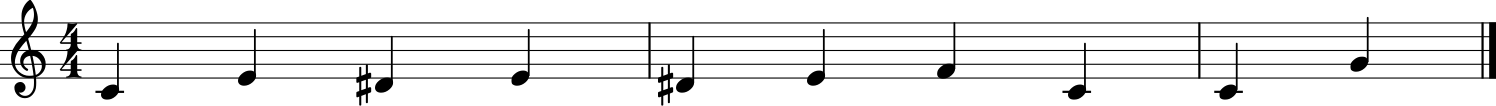

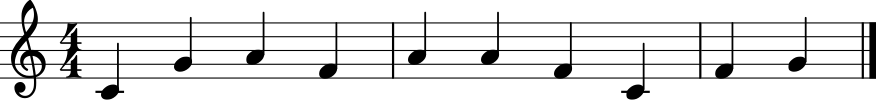

In [6]:
def all_notes():
    notes = []
    for o in range(OCTAVES):
        for p in PITCHES:

            notes.append(p + str(o+1))
    return notes
ALL_NOTES = all_notes()
ALL_NOTES[36]

def noteToIndex(n):
    return int(n.pitch.ps)-24

def getNext(matrix, n):
    idx = noteToIndex(n)
    transitions = matrix[idx,:]
    choice = np.random.choice(a=ALL_NOTES, p=transitions)
    return note.Note(choice)

def generateMelody(matrix, length):
    notes = []
    s = stream.Stream()
    start_note = note.Note('C4')
    n = start_note
    for i in range(length):
        s.append(n)
        n = getNext(matrix, n)
    return s

s = generateMelody(matrix, 10)
s.show()
s = generateMelody(matrix, 10)
s.show()
# s.show("midi")

In [25]:
""" 
Generates transition matrix for pitch to chord.
Currently filters for CM, can add in transposition later
"""
def generateTransitionMatrix(base_dir, load=True):
    path = 'pitch_to_pitch.npy'
    if load:
        with open(path, 'rb') as f:
            a = np.load(f)
        return a
    else:
        count = 0
        count_not = 0
        num_pieces = 500
        matrix = np.zeros((MATRIX_SIZE, MATRIX_SIZE), dtype=np.uintc)
        for i in range(len(os.listdir(base_dir))):
            f = os.listdir(base_dir)[i]
            try:
                path = os.path.join(base_dir,f)
                score = converter.parse(path)
            except: 
                continue
            score = transpose_to_c(score)
            k = score.analyze('key')
#             print(k,'\n')

            if k.name == "C major" or k.name == "A minor":
                m = getTransitions(score)
                matrix = matrix + m
                count += 1
            else:
                print("sad",k)
                print(k.name)
                count_not += 1

            if count >= num_pieces:
                break
        matrix = normalize(matrix)
        with open(path, 'wb+') as f:
            np.save(f, matrix)

        return matrix

matrix = generateTransitionMatrix(base_dir, load=False)
matrix.shape
# printTransitionMatrix(matrix)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    4    7    0   65   18
  130  102   68  999   85 1141  161 1133 4115  183 4063  393 6081 3075
  587 6987  487 5475  454 3075 6315  271 4222  370 4221 1418  284 1787
  120  924   46  297  338   19   97   11   42    3    4    2    0    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


(84, 84)